# RNN for image classification on MNIST dataset

### Importing libraries:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms 
import torch.nn as nn 
from torch import optim,utils
import os


### Loading the data:

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])

train_data= datasets.MNIST(train=True,root='/Users/tejasr/Documents/IITK/Semesters/sem 4 /Stamatics project /data',download = True,
                           transform=transform)
test_data= datasets.MNIST(train=False,root='/Users/tejasr/Documents/IITK/Semesters/sem 4 /Stamatics project /data',download = True,transform=transform)
print(train_data)
print(test_data)


Dataset MNIST
    Number of datapoints: 60000
    Root location: /Users/tejasr/Documents/IITK/Semesters/sem 4 /Stamatics project /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /Users/tejasr/Documents/IITK/Semesters/sem 4 /Stamatics project /data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [ ]:
batch_size=100

trainLoader= torch.utils.data.DataLoader(dataset= train_data, batch_size=batch_size, shuffle=True)
testLoader= torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

### Data Visualisation:

In [ ]:
# Exploring the dataset

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainLoader)
images, labels = dataiter.next()  #returns iterator and shifts pointer ahead to next position/image 
images_shape= images.shape
labels_shape= labels.shape
print("Image tensor is of size", images_shape,"\nLabels tensor is of size", labels_shape)


Image tensor is of size torch.Size([100, 1, 28, 28]) 
Labels tensor is of size torch.Size([100])


The image tensor is of size [100,1,28,28], meaning that each batch has 100 images, and each image is of size 28*28 pixels, and the corresponding labels size is 100, giving us the number classification of each digit. 

numpy.squeeze() removes single dimensional entities from the array, here a [1,28,28] image is converted into a [28,28] image which can be plotted 

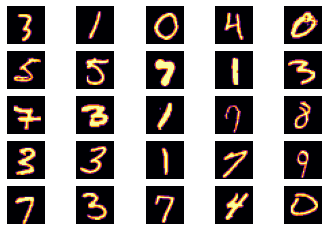

In [ ]:
figure = plt.figure()
for index in range(1, 26):
    plt.subplot(5, 5, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='inferno')

### Defining the model:

In [137]:
steps = 28
input_size = 28 # represents the size of the input at each time unit
hidden_size =60
output_size = 10 # equal to the number of classes= 10. 
n_epochs = 30
num_layers=1 #default, number of stacked LSTM layers
learning_rate=0.0001

In [138]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN,self).__init__()

        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.rnn= nn.RNN(self.input_size,self.hidden_size) #building an lstm
        self.fc= nn.Linear(self.hidden_size,self.output_size)
        
    def forward(self, x):
        h0= torch.zeros(self.num_layers, x.size(0), self.hidden_size )#Initial hidden state 
        c0= torch.zeros(self.num_layers, x.size(0), self.hidden_size ) #Initial cell state 
        #The lstm model requires these two input along with x 
        out,lstm= self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out 
        

In [139]:
# nn.Module[input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size,steps=steps,batch_size=batch_size]
model = RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
print(model)

RNN(
  (lstm): LSTM(28, 60, batch_first=True)
  (fc): Linear(in_features=60, out_features=10, bias=True)
)


### Defining the loss and the accuracy function:

In [140]:
criterion= nn.CrossEntropyLoss() #We use cross entropy loss 
optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate) #Adam is Adaptative Moment Estimation, improved SGD 

In [141]:
def accuracy(testLoader, model): #calculates the accuracy on the test dataset 
    correct=0
    total=0
    for images,labels in testLoader:
        images = images.reshape(-1, 28, input_size)
        output= model(images) #size of output.data.size() is [100,10]-> for each image in the batch we need to take the maximum along the rows
        #  print(output.data.size()," ",labels.size())
        #labels are of size [100] as expected 
        #torch.max returns a tuple, max_values, and max_indices 
        _, predictions = torch.max(output.data, 1)
        #Here, the max indices corresponds to the value of the predicted digit, if index 7 has the max value then we predict 7 and so on 
        assert(len(predictions)==len(labels))
        for i in range(0,len(predictions)):
            if(predictions[i]==labels[i]):
                correct+=1
        total+=len(predictions)    
    return correct/total
    # print(f"Accuracy is {correct/total:.4f} on the test dataset")

### Finally, training the model:

In [142]:
print(f"We iterate over a total of {n_epochs} epochs and train the model")
for epoch in range(0,n_epochs):
    for i, (images,labels) in enumerate(trainLoader):
        optimizer.zero_grad()
        images = images.reshape(-1, 28, input_size)
        output= model(images)
        loss= criterion(output, labels)
        loss.backward()
        optimizer.step()
    if(epoch%2):
        print(f"Loss in epoch {epoch+1} of {n_epochs} is: {loss.item():.4f}, with an accuracy of {accuracy(testLoader, model):.4f} on the test dataset")
    

We iterate over a total of 30 epochs and train the model
Loss in epoch 2 of 30 is: 0.7302, with an accuracy of 0.8199 on the test dataset
Loss in epoch 4 of 30 is: 0.3852, with an accuracy of 0.8955 on the test dataset
Loss in epoch 6 of 30 is: 0.3641, with an accuracy of 0.9145 on the test dataset
Loss in epoch 8 of 30 is: 0.1878, with an accuracy of 0.9292 on the test dataset
Loss in epoch 10 of 30 is: 0.2532, with an accuracy of 0.9372 on the test dataset
Loss in epoch 12 of 30 is: 0.3514, with an accuracy of 0.9427 on the test dataset
Loss in epoch 14 of 30 is: 0.2539, with an accuracy of 0.9459 on the test dataset
Loss in epoch 16 of 30 is: 0.0651, with an accuracy of 0.9518 on the test dataset
Loss in epoch 18 of 30 is: 0.2226, with an accuracy of 0.9513 on the test dataset
Loss in epoch 20 of 30 is: 0.1403, with an accuracy of 0.9514 on the test dataset
Loss in epoch 22 of 30 is: 0.0808, with an accuracy of 0.9604 on the test dataset
Loss in epoch 24 of 30 is: 0.1253, with an ac

In [143]:
correct=0
total=0

for images,labels in testLoader:
     images = images.reshape(-1, 28, input_size)
     output= model(images) #size of output.data.size() is [100,10]-> for each image in the batch we need to take the maximum along the rows
    #  print(output.data.size()," ",labels.size())
    #labels are of size [100] as expected 
    #torch.max returns a tuple, max_values, and max_indices 
     _, predictions = torch.max(output.data, 1)
     #Here, the max indices corresponds to the value of the predicted digit, if index 7 has the max value then we predict 7 and so on 
     assert(len(predictions)==len(labels))
     for i in range(0,len(predictions)):
         if(predictions[i]==labels[i]):
             correct+=1
     total+=len(predictions)    

print(f"Final accuracy with the trained model is {correct/total:.4f} on the test dataset")
     
     

Final accuracy with the trained model is 0.9648 on the test dataset


#### We get a final accuracy of 96.5% with the help of the RNN(LSTM) model!
##### The model gets higher accuracies much lesser number of epochs with around hundred hidden layers, but that model reaches almost peak accuracy in one epoch. 